In [1]:
from aerobulk import skin, noskin
import fsspec
import xarray as xr
import numpy as np
import xesmf as xe
import os
from intake import open_catalog
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar

In [2]:
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs)
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)


# instead do this
ds_atmos = ds_atmos.chunk({'time':1})

In [3]:
ds_atmos

<xarray.Dataset>
Dimensions:       (time: 7305, grid_yt: 360, grid_xt: 576, bnds: 2)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

In [3]:
import json
import gcsfs

# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
path = 'ocean-transport-group/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr'
mapper = fs.get_mapper(path)
ds_regridder = xr.open_zarr(mapper).load()
regridder = xe.Regridder(
    ds_atmos.olr.to_dataset(name='dummy').isel(time=0),
    ds_ocean.surface_temp.to_dataset(name='dummy').isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x576_2700x3600_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

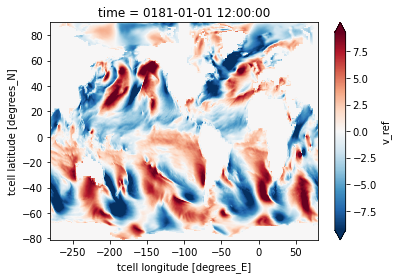

In [48]:
ds_atmos_regridded = regridder(ds_atmos[['slp', 'v_ref', 'u_ref', 't_ref', 'q_ref', 'swdn_sfc', 'lwdn_sfc']])
ds_atmos_regridded.v_ref.isel(time=0).plot(robust=True)

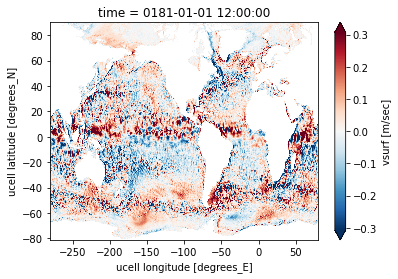

In [50]:
ds_ocean.vsurf.isel(time=0).plot(robust=True)

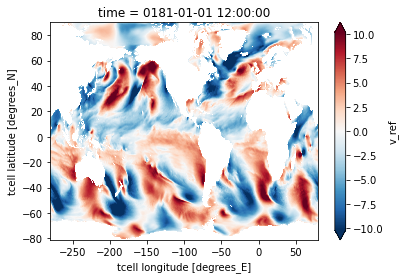

In [49]:
# relative wind instead of absolute
ds_ocean_renamed = ds_ocean[['usurf', 'vsurf']].rename({'xu_ocean':'xt_ocean','yu_ocean':'yt_ocean'}).drop(['xt_ocean', 'yt_ocean'])

ds_atmos_regridded['u_ref'] = ds_atmos_regridded['u_ref'] - ds_ocean_renamed.usurf
ds_atmos_regridded['v_ref'] = ds_atmos_regridded['v_ref'] - ds_ocean_renamed.vsurf
ds_atmos_regridded.v_ref.isel(time=0).plot(robust=True)

In [51]:
## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded,
        ds_ocean[['surface_temp']],
    ]
)
ds_merged = ds_merged.transpose(
    'xt_ocean', 'yt_ocean', 'time'
)

## Test the first month

In [52]:
ROI = dict(
    xt_ocean=slice(500, 2000),
    yt_ocean=slice(500, 2000),
)

In [53]:
ds = ds_merged.isel(
    time=slice(0,31),
    **ROI
)
ds

<xarray.Dataset>
Dimensions:       (yt_ocean: 1500, xt_ocean: 1500, time: 31)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -59.49 -59.44 -59.39 ... 59.9 59.95 60.0
  * xt_ocean      (xt_ocean) float64 -229.9 -229.8 -229.7 ... -80.15 -80.05
  * time          (time) object 0181-01-01 12:00:00 ... 0181-01-31 12:00:00
Data variables:
    slp           (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    v_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    u_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    t_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    q_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    swdn_sfc      (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    lwdn_sfc      (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
    surface_temp  (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(1500, 1500, 1), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

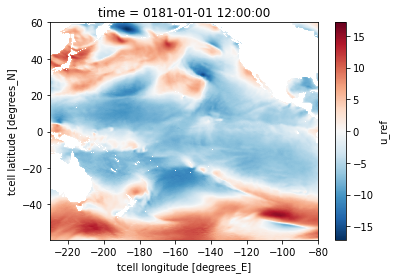

In [54]:
ds.isel(time=0).u_ref.plot(x='xt_ocean')

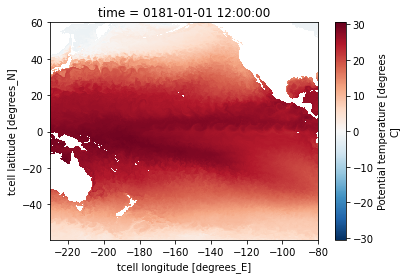

In [55]:
ds.isel(time=0).surface_temp.plot(x='xt_ocean')

In [56]:
with ProgressBar():
    ds = ds.load()

[########################################] | 100% Completed | 50.7s


In [57]:
ds

<xarray.Dataset>
Dimensions:       (yt_ocean: 1500, xt_ocean: 1500, time: 31)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -59.49 -59.44 -59.39 ... 59.9 59.95 60.0
  * xt_ocean      (xt_ocean) float64 -229.9 -229.8 -229.7 ... -80.15 -80.05
  * time          (time) object 0181-01-01 12:00:00 ... 0181-01-31 12:00:00
Data variables:
    slp           (xt_ocean, yt_ocean, time) float32 990.8 992.8 ... 1.019e+03
    v_ref         (xt_ocean, yt_ocean, time) float32 2.01 -0.8462 ... -6.007
    u_ref         (xt_ocean, yt_ocean, time) float32 5.739 5.536 ... 1.498
    t_ref         (xt_ocean, yt_ocean, time) float32 275.4 276.2 ... 252.0 245.2
    q_ref         (xt_ocean, yt_ocean, time) float32 0.003629 ... 0.0002929
    swdn_sfc      (xt_ocean, yt_ocean, time) float32 282.1 190.2 ... 32.29 40.05
    lwdn_sfc      (xt_ocean, yt_ocean, time) float32 264.8 294.9 ... 192.3 139.8
    surface_temp  (xt_ocean, yt_ocean, time) float32 3.836 3.92 ... -1.511
Attributes:
    regrid_method:  bilinear

In [58]:
def skin_ds_wrapper(ds_in):
    ds_out = xr.Dataset()
    ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.surface_temp + 273.15
    t_zt = ds_in.t_ref
    hum_zt = ds_in.q_ref
    u_zu = ds_in.u_ref
    v_zu = ds_in.v_ref
    rad_sw = ds_in.swdn_sfc
    rad_lw = ds_in.lwdn_sfc
    slp = ds_in.slp * 100 # check this
    zu = 10
    zt = 2
    
    # ql, qh, taux, tauy, ts, evap =  skin(
    #     sst,
    #     t_zt,
    #     hum_zt,
    #     u_zu,
    #     v_zu,
    #     rad_sw,
    #     rad_lw,
    #     slp=slp,
    #     algo='ecmwf',
    #     zt=2,
    #     zu=10,
    # )
    ql, qh, taux, tauy, evap =  noskin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp=slp,
        algo='ecmwf',
        zt=2,
        zu=10,
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    # ds_out['ts'] = ts
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    return ds_out

In [59]:
ds_full = skin_ds_wrapper(ds)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "ecmwf"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 01500 x 01500
     *** Number of time records that will be treated:          31
     *** Number of iterations in bulk algos: nb_iter  =    6
     *** Filling the `mask` array...
         ==> number of points to mask:       250733  (out of      2250000 )
     *** Type of prescribed air humidity  `specific humidity [kg/kg]`
                    ----- AeroBulk_bye -----
 


In [60]:
ds_full_average = ds_full.mean('time')
ds_full_average

<xarray.Dataset>
Dimensions:   (yt_ocean: 1500, xt_ocean: 1500)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -59.49 -59.44 -59.39 -59.34 ... 59.9 59.95 60.0
  * xt_ocean  (xt_ocean) float64 -229.9 -229.8 -229.7 ... -80.25 -80.15 -80.05
Data variables:
    ql        (xt_ocean, yt_ocean) float64 -20.85 -20.79 ... -81.99 -82.11
    qh        (xt_ocean, yt_ocean) float64 -6.665 -6.565 ... -220.9 -221.2
    evap      (xt_ocean, yt_ocean) float64 -8.371e-06 -8.344e-06 ... -3.278e-05
    taux      (xt_ocean, yt_ocean) float64 0.0637 0.06408 ... -0.02284 -0.02346
    tauy      (xt_ocean, yt_ocean) float64 -0.000311 -0.0007756 ... -0.01586

In [61]:
ds_flux.sens_heat

<xarray.DataArray 'sens_heat' (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<open_dataset-d6314618aafdae70f88131c0d95cf599sens_heat, shape=(240, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    long_name:      sensible heat into ocean (<0 cools ocean)
    standard_name:  surface_downward_sensible_heat_flux
    time_avg_info:  average_T1,average_T2,average_DT
    units:          W/m^2
    valid_range:    [-10000000000.0, 10000000000.0]

In [62]:
ds_flux_compare = ds_flux[['evap', 'evap_heat', 'sens_heat']].isel(**ROI, time=0).rename({'evap_heat':'ql', 'sens_heat':'qh'})

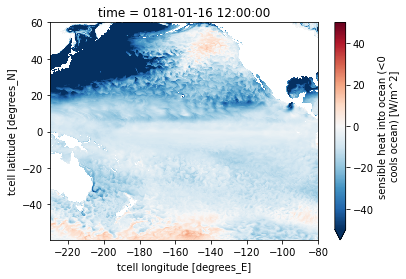

In [63]:
ds_flux_compare.qh.plot(vmax=50)

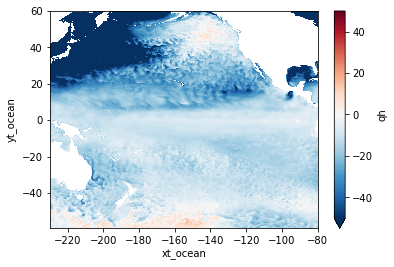

In [64]:
ds_full_average.qh.plot(vmax=50, x='xt_ocean')

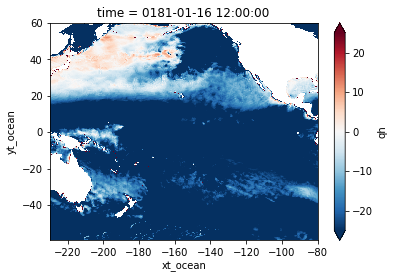

In [67]:
var = 'qh'

diff = (ds_full_average[var] - ds_flux_compare[var])/abs(ds_flux_compare[var])*100

diff.plot(x='xt_ocean', vmax=25)